# Read

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt
from matplotlib import pyplot as plt
import pickle
from loguru import logger

def butter_lowpass_filter(data, cutoff=0.3, fs=50, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='lowpass', analog=False, output='sos')
    y = sosfiltfilt(sos, data, axis=1)
    return y

In [2]:

full_data = sio.loadmat("/workspace/hdcle/data/UniMiB-SHAR/data/full_data.mat")
full_data = full_data["full_data"]

# Merge into Single Dataframe

In [3]:
df_all = []

# create a dataframe for each subject and assign gender, age, height and weight
# ------------------------------------------------------------------------------
for user_id in range(full_data.shape[0]):
    user_data = full_data[user_id, 0][0, 0]
    gender = "female" if full_data[user_id, 1][0].strip() == "F" else "male"
    age = full_data[user_id, 2][0][0]
    height = full_data[user_id, 3][0][0]
    weight = full_data[user_id, 4][0][0]

    label_names = [_[0] for _ in eval(str(user_data.dtype))]
    df_user = []

    # create a dataframe for each label and assign the label value
    # --------------------------------------------------------------------------
    for label_index, label_data in enumerate(user_data):
        # print(label_names[label_index], label_data.shape)
        df_label = []
        threshold = 1 if label_data.shape[0] == 2 else 3

        # create a dataframe for each trial and assign the trial number and position
        # ---------------------------------------------------------------------------
        for trial_id in range(label_data.shape[0]):
            position = "right" if trial_id < threshold else "left"
            trial_data = label_data[trial_id, 0]
            
            # Apply Butterworth low pass filter to the data
            trial_data[:3, :] -= butter_lowpass_filter(trial_data[:3, :])

            df_trial = pd.DataFrame(
                trial_data[[0, 1, 2, 4], :].T, columns=["x", "y", "z", "ts"]
            )
            if df_trial.isna().any().any():
                print(
                    f'NaN in user:{user_id}, label:{label_names[label_index]}, trial:{trial_id}. Dropping NaN.')
                # bad = df_trial.copy(deep=True)
                print(f'Before dropping: {df_trial.shape}')
                df_trial.dropna(inplace=True)
                print(f'After dropping: {df_trial.shape}')
                # continue

            df_trial["fold"] = trial_id
            df_trial["position"] = position

            df_label.append(df_trial)

        df_label = pd.concat(df_label, ignore_index=True)
        df_label["activity"] = label_names[label_index]

        df_user.append(df_label)

    df_user = pd.concat(df_user, ignore_index=True)
    df_user["subject"] = user_id
    # df_user.groupby(['subject', 'label', 'trial']).count()

    df_user["gender"] = gender
    df_user["age"] = age
    df_user["height"] = height
    df_user["weight"] = weight

    df_all.append(df_user)

df_all = pd.concat(df_all, ignore_index=True)
df_all


NaN in user:9, label:Jumping, trial:1. Dropping NaN.
Before dropping: (3208, 4)
After dropping: (0, 4)


,x,y,z,ts,fold,position,activity,subject,gender,age,height,weight
0,0.012808,-0.110931,-0.397158,5.26,0,right,Walking,0,female,24,170,68
1,-0.020451,-0.248185,-0.291571,5.28,0,right,Walking,0,female,24,170,68
2,-0.064517,-0.457213,-0.246853,5.30,0,right,Walking,0,female,24,170,68
3,-0.091789,-0.300110,-0.341079,5.32,0,right,Walking,0,female,24,170,68
4,-0.062020,-0.319372,-0.285728,5.34,0,right,Walking,0,female,24,170,68
...,...,...,...,...,...,...,...,...,...,...,...,...
741859,5.648018,0.675971,0.058971,11.38,5,left,HittingObstacle,29,male,23,170,55
741860,5.612206,0.722038,0.142673,11.40,5,left,HittingObstacle,29,male,23,170,55
741861,5.612140,0.656282,0.211872,11.42,5,left,HittingObstacle,29,male,23,170,55
741862,5.612087,0.706616,0.365065,11.44,5,left,HittingObstacle,29,male,23,170,55


In [4]:
# bad.plot(x='ts',y=['x', 'y', 'z'])
# bad.to_csv('/workspace/hdcle/data/preprocessed/shar/bad.csv')
# bad.dropna().shape

# Check for NaN Values

In [5]:
df_all[df_all.isna().any(axis=1)]#.groupby(['subject', 'activity', 'fold']).count()

,x,y,z,ts,fold,position,activity,subject,gender,age,height,weight


# Save

In [6]:
df_all.groupby(['subject', 'activity', 'fold']).count().to_csv(
    '/workspace/postdoc/imu_datasets/UniMiB-SHAR/full_data_count.csv')
df_all.to_csv('/workspace/postdoc/imu_datasets/UniMiB-SHAR//full_data.csv')

# Load

In [7]:
# df_all['label'].unique()
df_all = pd.read_csv('/workspace/postdoc/imu_datasets/UniMiB-SHAR//full_data.csv', index_col=0)

In [8]:
import matplotlib.pyplot as plt

# 17 labels including fall data
labels = [
    "Walking",
    "Running",
    "GoingUpS",
    "GoingDownS",
    "Jumping",
    "SittingDown",
    "StandingUpFS",
    "LyingDownFS",
    "StandingUpFL",
    # 
    "FallingForw",
    "FallingBack",
    "FallingRight",
    "FallingLeft",
    "Syncope",
    "FallingBackSC",
    "FallingWithPS",
    "HittingObstacle",
]

# only ADL label
labels = [
    "Walking",
    "Running",
    "GoingUpS",
    "GoingDownS",
    "Jumping",
    "SittingDown",
    "StandingUpFS",
    "LyingDownFS",
    "StandingUpFL",
]


In [9]:
df_all['fold'].unique()

array([0, 1, 2, 3, 4, 5])

In [10]:
# df_all[df_all['fold'] == 5]['activity'].unique()
df_all['position'].unique()

array(['right', 'left'], dtype=object)

# Plot

In [11]:

subject = 3
trial = 0


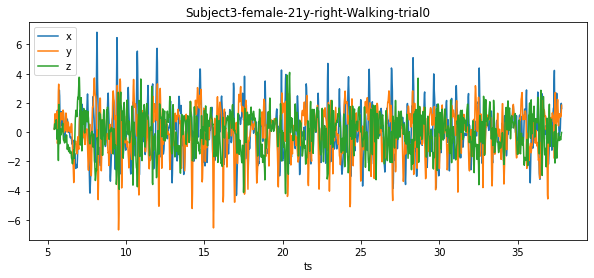

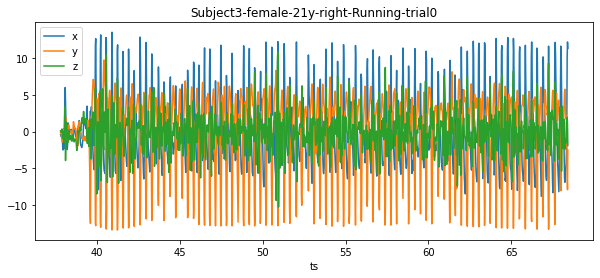

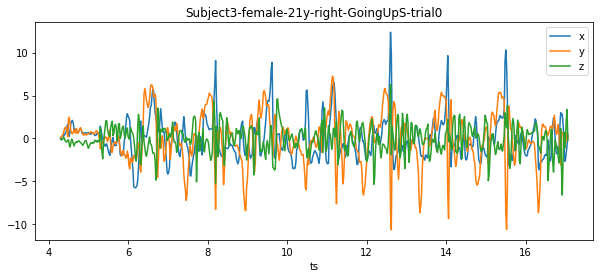

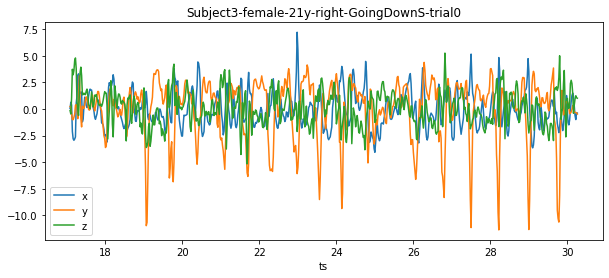

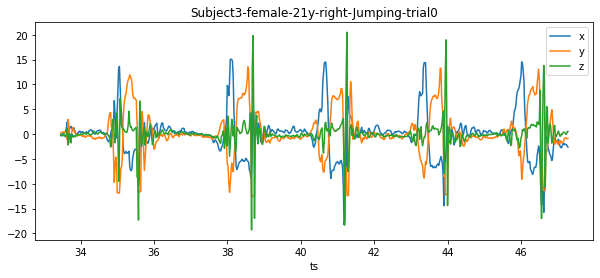

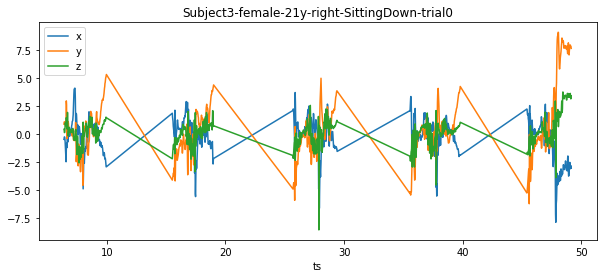

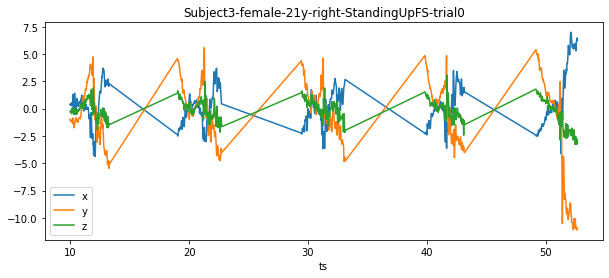

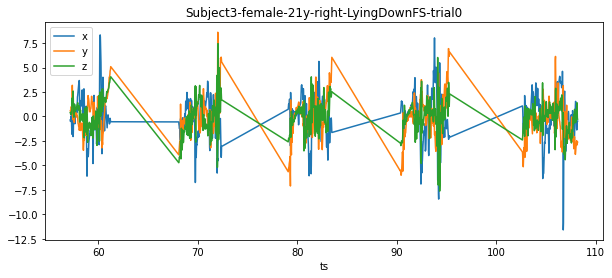

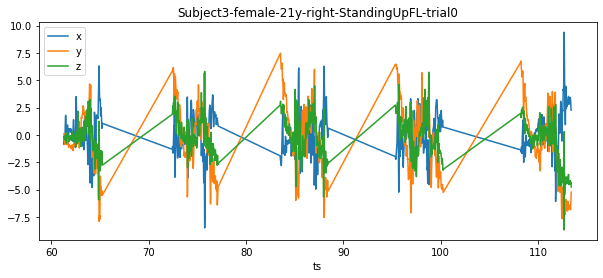

In [12]:

for label in labels:
    selected = df_all[
        (df_all["subject"] == subject) & (df_all["activity"] == label) & (df_all["fold"] == trial)].sort_values(by='ts').reset_index(drop=True)
    title = f"Subject{subject}-{selected['gender'].iloc[0]}-{selected['age'].iloc[0]}y-{selected['position'].iloc[0]}-{label}-trial{trial}"
    selected.plot(x='ts', y=['x', 'y', 'z'], figsize=(10, 4), title=title)
    # selected.plot(y=['x', 'y', 'z'], figsize=(20, 4), title=title)
    # break


# Resample

In [13]:
data_cols = ['x', 'y', 'z']
label_cols = ['ts', 'activity', 'subject', 'weight', 'height', 'age', 'gender', 'fold', 'position']
# label_cols = ['activity', 'subject', 'weight', 'height', 'age', 'gender', 'fold', 'position']

In [14]:

from scipy import signal
from scipy.interpolate import interp1d
import numpy as np


def resample(df, fs_orig=50, fs_new=30):
    """
    Resample a dataframe with a given sampling frequency.

    :param df: dataframe to be resampled
    :param fs_orig: original sampling frequency
    :param fs_new: new sampling frequency
    """
    global data_cols, label_cols
    n_samples_new = int(df.shape[0] / fs_orig * fs_new)
    resampled = signal.resample(df[data_cols], n_samples_new, axis=0)
    # resampled = signal.resample_poly(df[data_cols], up=3, down=5, axis=0)
    resampled = pd.DataFrame(resampled, columns=data_cols)
    new_timestamps = np.linspace(df.index.min(), df.index.max(), n_samples_new)
    fn_interp = interp1d(df.index, np.arange(df.shape[0]), kind='nearest')
    new_idx = fn_interp(new_timestamps).astype(int)
    resampled[label_cols] = df.iloc[new_idx][label_cols].reset_index(drop=True)
    return resampled

In [15]:
# trial_samples

In [16]:
# labels

In [17]:
def resample_dataset(dataset, fs_orig=50, fs_new=30):
    """
    Resample a dataset with a given sampling frequency.

    :param dataset: dataset to be resampled
    :param fs_orig: original sampling frequency
    :param fs_new: new sampling frequency
    """
    result = []
    for user in sorted(dataset['subject'].unique()):
        print('Resampling user {} ...'.format(user))
        user_samples = dataset[dataset['subject'] == user]

        # for act_label in sorted(user_samples['activity'].unique()):
        for act_label in labels:
            print('Resampling activity {} ...'.format(act_label))
            act_samples = user_samples[user_samples['activity'] == act_label]

            for trial in sorted(act_samples['fold'].unique()):
                print('Resampling trial {} ...'.format(trial))
                trial_samples = act_samples[act_samples['fold'] == trial].copy(deep=True)
                trial_samples.sort_values(by='ts', inplace=True)
                trial_samples.reset_index(inplace=True, drop=True)
                resampled = resample(trial_samples, fs_orig, fs_new)
                print('Resampled from {} to {} samples'.format(trial_samples.shape[0], resampled.shape[0]))
                result.append(resampled)
    result = pd.concat(result, ignore_index=True)
    return result

resampled = resample_dataset(df_all, fs_orig=50, fs_new=30)

Resampling user 0 ...
Resampling activity Walking ...
Resampling trial 0 ...
Resampled from 1863 to 1117 samples
Resampling trial 1 ...
Resampled from 1632 to 979 samples
Resampling activity Running ...
Resampling trial 0 ...
Resampled from 1432 to 859 samples
Resampling trial 1 ...
Resampled from 1572 to 943 samples
Resampling activity GoingUpS ...
Resampling trial 0 ...
Resampled from 795 to 477 samples
Resampling trial 1 ...
Resampled from 695 to 417 samples
Resampling activity GoingDownS ...
Resampling trial 0 ...
Resampled from 801 to 480 samples
Resampling trial 1 ...
Resampled from 617 to 370 samples
Resampling activity Jumping ...
Resampling trial 0 ...
Resampled from 1017 to 610 samples
Resampling trial 1 ...
Resampled from 977 to 586 samples
Resampling activity SittingDown ...
Resampling trial 0 ...
Resampled from 462 to 277 samples
Resampling trial 1 ...
Resampled from 522 to 313 samples
Resampling activity StandingUpFS ...
Resampling trial 0 ...
Resampled from 472 to 283 sa

In [18]:
resampled.shape

(282181, 12)

In [19]:
resampled[resampled.isna().any(axis=1)]


,x,y,z,ts,activity,subject,weight,height,age,gender,fold,position


# Plot after Resampling

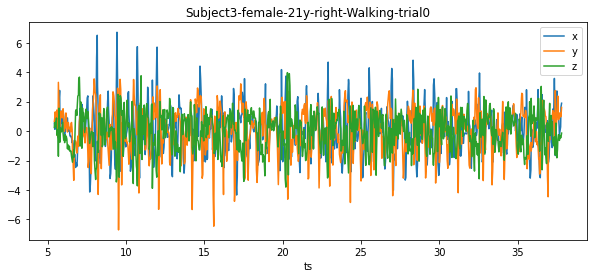

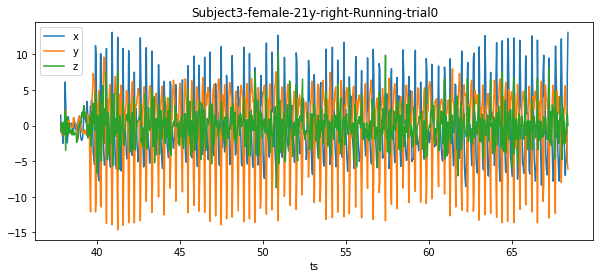

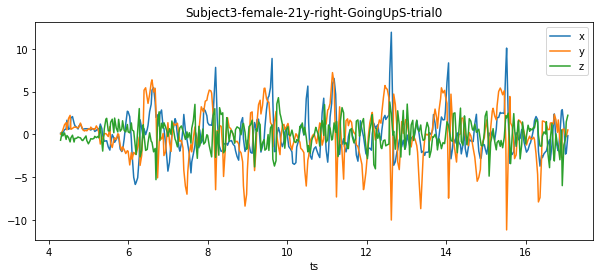

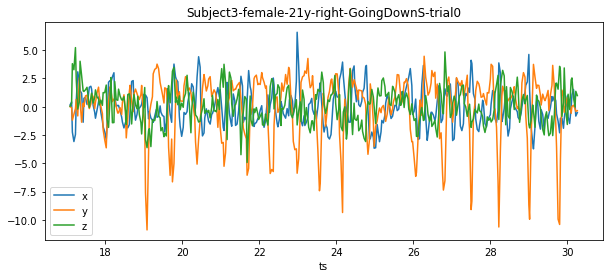

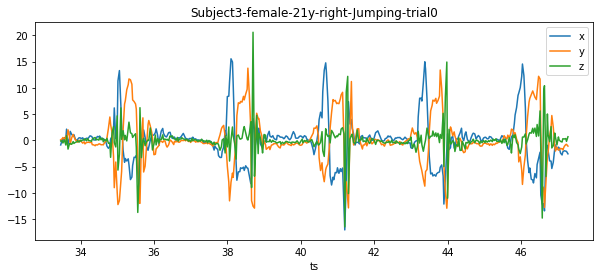

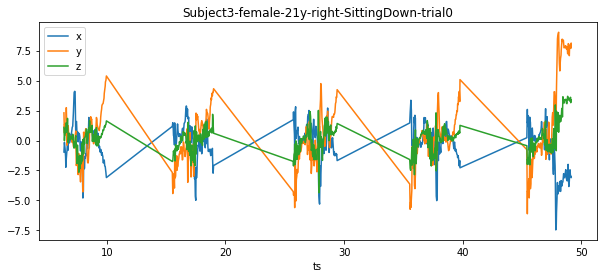

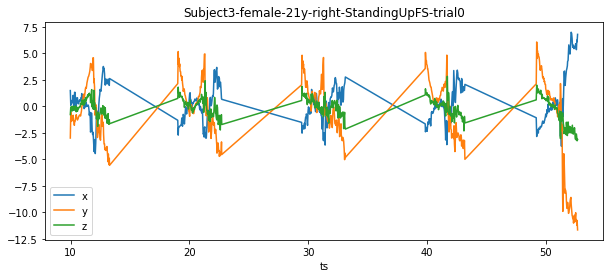

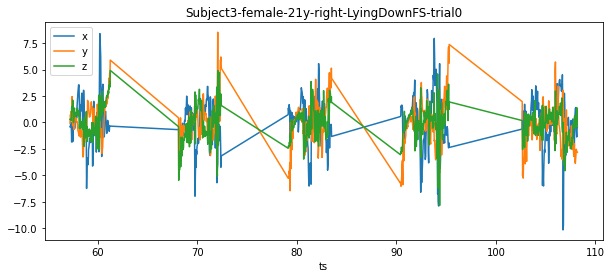

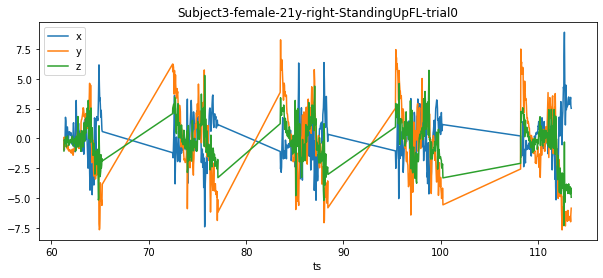

In [20]:
for label in labels:
    selected = resampled[
        (resampled["subject"] == subject) & (resampled["activity"] == label) & (resampled["fold"] == trial)]
        #.sort_values(by='ts')
    title = f"Subject{subject}-{selected['gender'].iloc[0]}-{selected['age'].iloc[0]}y-{selected['position'].iloc[0]}-{label}-trial{trial}"
    selected.plot(x='ts', y=['x', 'y', 'z'], figsize=(10, 4), title=title)
    # selected.reset_index(drop=True).plot(y=['x', 'y', 'z'], figsize=(20, 4), title=title)
    # break

In [21]:
# plt.figure(figsize=(20, 4))
# plt.plot(selected[['x', 'y', 'z']].values)
resampled.head()

,x,y,z,ts,activity,subject,weight,height,age,gender,fold,position
0,-0.055064,-0.141759,-0.102660,5.26,Walking,0,68,170,24,female,0,right
1,-0.017367,-0.335263,-0.406304,5.30,Walking,0,68,170,24,female,0,right
2,-0.108816,-0.359650,-0.208952,5.32,Walking,0,68,170,24,female,0,right
3,-0.049101,-0.345542,-0.345900,5.36,Walking,0,68,170,24,female,0,right
4,-0.052599,-0.386226,-0.323870,5.40,Walking,0,68,170,24,female,0,right


# Some Stats of the Dataset

## Age

In [22]:
resampled.groupby('age').count()['activity']

age
18    24076
19    23086
20    17912
21    39486
22    15860
23    10175
24    60230
25     8260
26    21019
28    10441
29    11572
49     8928
54     9178
55    10919
60    11039
Name: activity, dtype: int64

## Male vs Female Sample Count

In [23]:
resampled.groupby(['gender', 'subject']).count()['activity'].to_dict()

{('female', 0): 9456,
 ('female', 2): 8928,
 ('female', 3): 11395,
 ('female', 4): 8761,
 ('female', 5): 12785,
 ('female', 7): 10919,
 ('female', 9): 10993,
 ('female', 10): 8002,
 ('female', 11): 7821,
 ('female', 12): 8572,
 ('female', 14): 8337,
 ('female', 15): 7263,
 ('female', 16): 7777,
 ('female', 17): 8260,
 ('female', 18): 8681,
 ('female', 19): 7288,
 ('female', 20): 9631,
 ('female', 21): 7530,
 ('female', 22): 7865,
 ('female', 23): 8681,
 ('female', 24): 10267,
 ('female', 26): 10433,
 ('female', 27): 10586,
 ('female', 28): 11264,
 ('male', 1): 9178,
 ('male', 6): 11039,
 ('male', 8): 11572,
 ('male', 13): 8281,
 ('male', 25): 10441,
 ('male', 29): 10175}

## Activity Distribution per User

In [24]:
for f in sorted(resampled['subject'].unique()):
    subject = resampled[resampled['subject'] == f]
    gender = subject['gender'].unique()[0]
    # label_dist = (subject['activity'].value_counts() / subject['activity'].count()).to_dict()
    label_dist = subject['activity'].value_counts().to_dict()
    print('User {}, {}: {}\n'.format(f, gender, dict(sorted(label_dist.items()))))

User 0, female: {'GoingDownS': 850, 'GoingUpS': 894, 'Jumping': 1196, 'LyingDownFS': 736, 'Running': 1802, 'SittingDown': 590, 'StandingUpFL': 696, 'StandingUpFS': 596, 'Walking': 2096}

User 1, male: {'GoingDownS': 653, 'GoingUpS': 679, 'Jumping': 1272, 'LyingDownFS': 751, 'Running': 1897, 'SittingDown': 599, 'StandingUpFL': 610, 'StandingUpFS': 604, 'Walking': 2113}

User 2, female: {'GoingDownS': 694, 'GoingUpS': 694, 'Jumping': 746, 'LyingDownFS': 794, 'Running': 1873, 'SittingDown': 631, 'StandingUpFL': 985, 'StandingUpFS': 727, 'Walking': 1784}

User 3, female: {'GoingDownS': 756, 'GoingUpS': 788, 'Jumping': 856, 'LyingDownFS': 1474, 'Running': 1818, 'SittingDown': 1128, 'StandingUpFL': 1537, 'StandingUpFS': 1072, 'Walking': 1966}

User 4, female: {'GoingDownS': 753, 'GoingUpS': 746, 'Jumping': 789, 'LyingDownFS': 711, 'Running': 1888, 'SittingDown': 609, 'StandingUpFL': 657, 'StandingUpFS': 617, 'Walking': 1991}

User 5, female: {'GoingDownS': 715, 'GoingUpS': 742, 'Jumping': 96

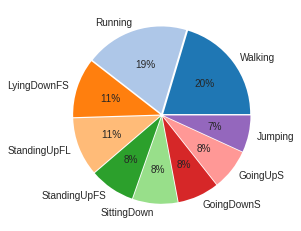

In [25]:
# %matplotlib inline
import seaborn as sns
palette = sns.color_palette("tab20")
plt.style.use("seaborn-darkgrid")

dist = df_all[df_all['activity'].isin(labels)]['activity'].value_counts()
# f = plt.figure(figsize=(6, 6))
f = plt.figure(figsize=(4, 4))
plt.pie(
    x=dist.values,
    labels=dist.keys(),
    colors=palette,
    autopct="%.0f%%",
    explode=[0.02 for _ in range(len(dist))],
)
# f.savefig("shar.pdf", bbox_inches="tight")

## Breakdown by Subject, Activity and Fold

In [26]:
resampled.groupby(['fold']).count()

,x,y,z,ts,activity,subject,weight,height,age,gender,position
fold,,,,,,,,,,,
0,142043,142043,142043,142043,142043,142043,142043,142043,142043,142043,142043
1,140138,140138,140138,140138,140138,140138,140138,140138,140138,140138,140138


In [27]:
# resampled.groupby(['subject', 'activity']).count()['x']
# resampled[resampled['fold'] == 1]['subject'].unique()
resampled.groupby(['position', 'subject']).count()['activity']

position  subject
left      0          4664
          1          4627
          2          4325
          3          5805
          4          4394
          5          6325
          6          5446
          7          5350
          8          5757
          9          5265
          10         3982
          11         3871
          12         4070
          13         4083
          14         4206
          15         3583
          16         3857
          17         4142
          18         4405
          19         3538
          20         4742
          21         3782
          22         3884
          23         4312
          24         5143
          25         5196
          26         5166
          27         5365
          28         5760
          29         5093
right     0          4792
          1          4551
          2          4603
          3          5590
          4          4367
          5          6460
          6          5593
          7         

In [28]:
# resampled.groupby(['subject', 'activity', 'fold'])['x'].value_counts().to_csv('/workspace/hdcle/data/preprocessed/shar/temp.csv')
# resampled.groupby(['subject', 'fold'])['x'].count().to_csv('/workspace/hdcle/data/preprocessed/shar/temp.csv')
resampled.groupby(['subject', 'fold', 'activity']).count()['x'].to_csv('/workspace/postdoc/imu_datasets/UniMiB-SHAR/subject-activity-fold-count.csv')

# Window Creation

In [29]:
window_len = 90
# offset = 9
offset = 45
keep_fraction_per_trial = 1.

def extract_features(dataset, window_len, offset, keep_fraction_per_trial):
    """
    Extract features from a dataset.

    :param dataset: dataset to be extracted
    :param window_len: length of the window
    :param offset: offset between windows
    """
    global data_cols, label_cols
    result = []
    for user in sorted(dataset['subject'].unique()):
        print('Extracting features for user {}'.format(user))
        print('================================')
        user_samples = dataset[dataset['subject'] == user]

        for act_label in sorted(user_samples['activity'].unique()):
            print('Extracting features for activity {}'.format(act_label))
            print('------------------------------------')
            act_samples = user_samples[user_samples['activity'] == act_label]
            # return

            for trial in sorted(act_samples['fold'].unique()):
                print('Extracting features for trial {}'.format(trial))
                # print('.................................')
                trial_samples = act_samples[act_samples['fold'] == trial].copy(deep=True)
                print('{} samples'.format(trial_samples.shape[0]))
                trial_samples.reset_index(inplace=True, drop=True)
                trial_samples = trial_samples[:int(keep_fraction_per_trial * trial_samples.shape[0])]
                if keep_fraction_per_trial < 1:
                    print('{} samples after dropping'.format(trial_samples.shape[0]))
                for i in range(0, trial_samples.shape[0] - window_len, offset):
                    window = trial_samples.iloc[i:i + window_len].copy(deep=True)
                    window = window.reset_index(drop=True)

                    # no overlapping activities
                    if len(window['activity'].unique()) == 1:
                        result.append(window)
                print(f'{i} windows')
                # return

    return result


# train_windows = extract_features(train_resampled, window_len=90, offset=45)
# test_windows = extract_features(test_resampled, window_len=90, offset=45)
windows = extract_features(resampled, window_len, offset, keep_fraction_per_trial)


Extracting features for user 0
Extracting features for activity GoingDownS
------------------------------------
Extracting features for trial 0
480 samples
387 windows
Extracting features for trial 1
370 samples
279 windows
Extracting features for activity GoingUpS
------------------------------------
Extracting features for trial 0
477 samples
378 windows
Extracting features for trial 1
417 samples
324 windows
Extracting features for activity Jumping
------------------------------------
Extracting features for trial 0
610 samples
513 windows
Extracting features for trial 1
586 samples
495 windows
Extracting features for activity LyingDownFS
------------------------------------
Extracting features for trial 0
347 samples
252 windows
Extracting features for trial 1
389 samples
297 windows
Extracting features for activity Running
------------------------------------
Extracting features for trial 0
859 samples
765 windows
Extracting features for trial 1
943 samples
846 windows
Extracting 

In [30]:
# windows[0][['x', 'y', 'z']].plot()
windows[0]

,x,y,z,ts,activity,subject,weight,height,age,gender,fold,position
0,0.281162,-0.136193,-0.380834,20.32,GoingDownS,0,68,170,24,female,0,right
1,-0.017879,0.008046,-0.386001,20.36,GoingDownS,0,68,170,24,female,0,right
2,-0.080268,-0.184253,-1.216373,20.38,GoingDownS,0,68,170,24,female,0,right
3,-0.954815,0.004291,-1.184488,20.42,GoingDownS,0,68,170,24,female,0,right
4,-0.411314,-0.027022,-0.859181,20.46,GoingDownS,0,68,170,24,female,0,right
...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.060543,-3.427411,1.130970,23.16,GoingDownS,0,68,170,24,female,0,right
86,1.058161,-0.791162,1.974126,23.20,GoingDownS,0,68,170,24,female,0,right
87,0.541152,-1.595093,1.381423,23.22,GoingDownS,0,68,170,24,female,0,right
88,-0.224741,-1.887025,1.136908,23.26,GoingDownS,0,68,170,24,female,0,right


# Save file in Pickes

In [31]:
import os
version = f'window_len={window_len}+offset={offset}+fraction_per_trial={keep_fraction_per_trial}'
logger.info(version)
os.makedirs(f'/workspace/postdoc/imu_datasets/UniMiB-SHAR/{version}', exist_ok=True)
with open(f'/workspace/postdoc/imu_datasets/UniMiB-SHAR/{version}/windows.pkl', 'wb') as f:
    pickle.dump(windows, f)


2023-07-10 14:29:53.324 | INFO     | __main__:<module>:3 - window_len=90+offset=9+fraction_per_trial=1.0
